In [3]:
import os
import matplotlib.pyplot as plt
from PIL import Image  
import numpy as np
import random
import h5py

In [4]:
h5f = h5py.File('LowRes_13434_overlapping_pairs.h5','r')
xdata = h5f['dataset_1'][...,0]
labels = h5f['dataset_1'][...,1]
h5f.close()

In [5]:
def findNearestNeighbourLabel(array):
    center = int(array.shape[0]/2)
    labels_count = np.zeros(5)
    for x in range(array.shape[0]):
        for y in range(array.shape[1]):
            if (x != center) or (y != center):
                temp_label = array[x, y]
                labels_count[temp_label] += 1
    return labels_count.argmax()
    

In [6]:
def cleanLabelNearestNeighbour(label):
    '''
    Corrects incorrect labels in a single image based on a threshold on the number of 
    nearest neighbours with the same label
    '''
    x_length = label.shape[0]
    y_length = label.shape[1]
    num_of_classes = 4
    cleaned_labels = np.zeros((x_length, y_length, 4))
    for x in range(1,x_length-1):
        for y in range(1, y_length-1):
            temp_label = label[x,y]
            if temp_label >3: # if labeled as 4 or above
                temp_label = findNearestNeighbourLabel(label[(x-1):(x+2), (y-1):(y+2)])
                cleaned_labels[x, y, temp_label] = 1
            elif temp_label > 0:
                num_labels_in_3x3 = len(np.where(label[(x-1):(x+2), (y-1):(y+2)]==temp_label)[0])
                if num_labels_in_3x3 > 3:
                    cleaned_labels[x, y, temp_label] = 1
                else:
                    temp_label = findNearestNeighbourLabel(label[(x-1):(x+2), (y-1):(y+2)])
                    cleaned_labels[x, y, temp_label] = 1
        non_zero_array = cleaned_labels[..., 1:].sum(axis=2).astype('bool')
        cleaned_labels[..., 0] = np.ones((x_length, y_length), dtype='bool')^non_zero_array
    return cleaned_labels

def cleanLabelNearestNeighbour_alllabels(labels):    
    '''
    Cleans incorrect labels
    '''
    num_labels = labels.shape[0]
    num_of_classes = 4
    cleaned_dim = list(labels.shape)
    cleaned_dim.append(num_of_classes)
    cleaned_labels = np.zeros(cleaned_dim)
    for image_i in range(num_labels):
        # print('Preprocessing image %d of %d' % (image_i, num_labels))
        cleaned_labels[image_i,...] = cleanLabelNearestNeighbour(labels[image_i, ...])
    return cleaned_labels

In [7]:
def plotSamplesOneHots(labels_of_samples, output_file=False):
    '''
    labels_of_samples of shape (num_samples, x, y, num_onehots)
    '''
    if len(labels_of_samples.shape) != 4:
        print("Incorrect input size - should be (num_samples, x, y, num_onehots)")
    num_samples = labels_of_samples.shape[0]
    num_onehots = labels_of_samples.shape[-1]
    figure_size = (4*num_onehots, 4*num_samples)
    fig, ax = plt.subplots(num_samples, num_onehots, sharex=True, sharey=True, figsize=figure_size)
    for i in range(num_samples):
        for j in range(num_onehots):
            ax[i, j].imshow(labels_of_samples[i,...,j], aspect="auto")
    fig.tight_layout()
    plt.show()
    if output_file == True:
        fig.savefig(output_file)

def IOU(y_pred, y_true):
    '''
    Calculate the IOU for each class seperately
    '''
    if len(y_pred.shape) < 4 or (y_pred.shape[3]<4):
        print('Wrong dimensions: one hot encoding expected')
        return
    y_pred = y_pred.astype('bool')
    y_true = y_true.astype('bool')
    IUs = []
    for layer in range(y_true.shape[3]):
        intersection = y_pred[...,layer] & y_true[...,layer]
        union = y_pred[...,layer] | y_true[...,layer]
        if union.sum() == 0:
            IUs.append(1)
        else:
            IUs.append(intersection.sum()/union.sum())
    return IUs

def globalAccuracy(y_pred, y_true):
    '''
    Calculate the global accuracy (ie. percent of pixels correctly labelled)
    '''
    y_pred = y_pred.astype('bool')
    y_true = y_true.astype('bool')
    correct = y_pred & y_true
    num_correct = correct.sum()
    num_total = 1
    for dim in y_true.shape[0:-1]:
        num_total = num_total*dim
    return num_correct/num_total

In [8]:
# Clean labels
labels = cleanLabelNearestNeighbour_alllabels(labels)

In [9]:
def makeXbyY(data, X, Y):
    '''
    Crop data to size X by Y
    '''
    if len(data.shape) < 3:
        print('Input should be of size (num_samples, x, y,...)')
    data_x_start = int((data.shape[1]-X)/2)
    data_y_start = int((data.shape[1]-Y)/2)
    arrayXbyY = data[:, (data_x_start):(data_x_start + X), (data_y_start):(data_y_start + Y),...]
    return arrayXbyY

In [10]:
labels = makeXbyY(labels, 84, 84)

In [11]:
xdata = makeXbyY(xdata, 84, 84).reshape((13434, 84, 84, 1))

In [12]:
datanum = [i for i in range(0,13434)]
testnum = random.sample(datanum, int(len(datanum)/10))
for i in testnum:
    datanum.remove(i)

In [13]:
print(len(datanum)+len(testnum))

13434


In [14]:
x_test = xdata[testnum,...]
labels_test = labels[testnum,...]

In [2]:
from __future__ import print_function
from __future__ import absolute_import

import warnings

from keras.models import Model
from keras.layers import Flatten
from keras.layers import Dense
from keras.layers import Input
from keras.layers import Conv2D
from keras.layers import Conv2DTranspose
from keras.layers import MaxPooling2D
from keras.layers import GlobalAveragePooling2D
from keras.layers import GlobalMaxPooling2D
from keras.layers import concatenate
from keras.engine.topology import get_source_inputs
from keras.utils import layer_utils
from keras.utils.data_utils import get_file
from keras import backend as K
from keras import callbacks

In [19]:
def Half_UNet(input_tensor=None, input_shape=None, pooling=None):

    if input_tensor is None:
        img_input = Input(shape=input_shape)
    else:
        if not K.is_keras_tensor(input_tensor):
            img_input = Input(tensor=input_tensor, shape=input_shape)
        else:
            img_input = input_tensor
    # Block 1
    x = Conv2D(64, (3, 3), activation='relu', padding='same', name='block1_conv1')(img_input)
    x_1a = Conv2D(64, (3, 3), activation='relu', padding='same', name='block1_conv2')(x)
    x = MaxPooling2D((2, 2), strides=(2, 2), name='block1_pool')(x_1a)

    # Block 2
    x = Conv2D(128, (3, 3), activation='relu', padding='same', name='block2_conv1')(x)
    x_2a = Conv2D(128, (3, 3), activation='relu', padding='same', name='block2_conv2')(x)
    x = MaxPooling2D((2, 2), strides=(2, 2), name='block2_pool')(x_2a)


    # Block 3
    x = Conv2D(256, (3, 3), activation='relu', padding='same', name='block3_conv1')(x)
    x = Conv2D(256, (3, 3), activation='relu', padding='same', name='block3_conv2')(x)

    x_2b = Conv2DTranspose(128, (2, 2), strides=(2, 2), input_shape=(None,23, 23, 1), name='block3_deconv1')(x)

    # Deconv Block 1
    x = concatenate([x_2a, x_2b])#, axis=-1)
    x = Conv2D(filters=128, kernel_size=(3, 3), activation='relu', padding='same', name='dblock1_conv1')(x)
    x = Conv2D(128, (3, 3), activation='relu', padding='same', name='dblock1_conv2')(x)
    x_1b = Conv2DTranspose(64, kernel_size=(2, 2), strides=(2, 2), name='dblock1_deconv')(x)

    # Deconv Block 2
    x = concatenate([x_1a, x_1b], input_shape=(None,92, 92, None))#, axis=-1, name='dbock2_concat') # keras.layers.concatenate([encoded_a, encoded_b], axis=-1)
    x = Conv2D(64, (3, 3), activation='relu', padding='same', name='dblock2_conv1')(x)
    x = Conv2D(64, (3, 3), activation='relu', padding='same', name='dblock2_conv2')(x)
    # Output convolution. Number of filters should equal number of channels of the output
    x = Conv2D(4, (1, 1), activation=None, padding='same', name='dblock2_conv3')(x)

    # Ensure that the model takes into account
    # any potential predecessors of `input_tensor`.
    if input_tensor is not None:
        inputs = get_source_inputs(input_tensor)
    else:
        inputs = img_input
    # Create model
    model = Model(inputs, x, name='OverlapSegmentationNet')

    return model


In [27]:
def UNet(input_tensor=None, input_shape=None, pooling=None):

    if input_tensor is None:
        img_input = Input(shape=input_shape)
    else:
        if not K.is_keras_tensor(input_tensor):
            img_input = Input(tensor=input_tensor, shape=input_shape)
        else:
            img_input = input_tensor
    # Block 1
    x = Conv2D(64, (3, 3), activation='relu', padding='same', name='block1_conv1')(img_input)
    x_1a = Conv2D(64, (3, 3), activation='relu', padding='same', name='block1_conv2')(x)
    x = MaxPooling2D((2, 2), strides=(2, 2), name='block1_pool')(x_1a)

    # Block 2
    x = Conv2D(128, (3, 3), activation='relu', padding='same', name='block2_conv1')(x)
    x_2a = Conv2D(128, (3, 3), activation='relu', padding='same', name='block2_conv2')(x)
    x = MaxPooling2D((2, 2), strides=(2, 2), name='block2_pool')(x_2a)

    # Block 3
    x = Conv2D(256, (3, 3), activation='relu', padding='same', name='block3_conv1')(x)
    x_3a = Conv2D(256, (3, 3), activation='relu', padding='same', name='block3_conv2')(x)
    x = MaxPooling2D((2, 2), strides=(2, 2), name='block2_pool')(x_3a)

    # Block 4
    x = Conv2D(512, (3, 3), activation='relu', padding='same', name='block3_conv1')(x)
    x_4a = Conv2D(512, (3, 3), activation='relu', padding='same', name='block3_conv2')(x)
    x = MaxPooling2D((2, 2), strides=(2, 2), name='block2_pool')(x_4a)
    
    # Block 5
    x = Conv2D(1024, (3, 3), activation='relu', padding='same', name='block3_conv1')(x)
    x = Conv2D(1024, (3, 3), activation='relu', padding='same', name='block3_conv2')(x)       
    
    x_4b = Conv2DTranspose(512, (2, 2), strides=(2, 2), input_shape=(None,6, 6, 1), name='block5_deconv1')(x)

    # Deconv Block 1
    x = concatenate([x_4a, x_4b])#, axis=-1)
    x = Conv2D(filters=512, kernel_size=(3, 3), activation='relu', padding='same', name='dblock1_conv1')(x)
    x = Conv2D(512, (3, 3), activation='relu', padding='same', name='dblock1_conv2')(x)
    x_3b = Conv2DTranspose(256, kernel_size=(2, 2), strides=(2, 2), name='dblock1_deconv')(x)

    # Deconv Block 1
    x = concatenate([x_3a, x_3b])#, axis=-1)
    x = Conv2D(filters=256, kernel_size=(3, 3), activation='relu', padding='same', name='dblock1_conv1')(x)
    x = Conv2D(256, (3, 3), activation='relu', padding='same', name='dblock1_conv2')(x)
    x_2b = Conv2DTranspose(128, kernel_size=(2, 2), strides=(2, 2), name='dblock1_deconv')(x)
    
    # Deconv Block 1
    x = concatenate([x_2a, x_2b])#, axis=-1)
    x = Conv2D(filters=128, kernel_size=(3, 3), activation='relu', padding='same', name='dblock1_conv1')(x)
    x = Conv2D(128, (3, 3), activation='relu', padding='same', name='dblock1_conv2')(x)
    x_1b = Conv2DTranspose(64, kernel_size=(2, 2), strides=(2, 2), name='dblock1_deconv')(x)

    # Deconv Block 2
    x = concatenate([x_1a, x_1b], input_shape=(None,92, 92, None))#, axis=-1, name='dbock2_concat') # keras.layers.concatenate([encoded_a, encoded_b], axis=-1)
    x = Conv2D(64, (3, 3), activation='relu', padding='same', name='dblock2_conv1')(x)
    x = Conv2D(64, (3, 3), activation='relu', padding='same', name='dblock2_conv2')(x)
    # Output convolution. Number of filters should equal number of channels of the output
    x = Conv2D(4, (1, 1), activation=None, padding='same', name='dblock2_conv3')(x)

    # Ensure that the model takes into account
    # any potential predecessors of `input_tensor`.
    if input_tensor is not None:
        inputs = get_source_inputs(input_tensor)
    else:
        inputs = img_input
    # Create model
    model = Model(inputs, x, name='OverlapSegmentationNet')

    return model


In [28]:
# train_test_boundary_index = round(13434*.8)

In [30]:
model = Half_UNet(input_shape=(84,84,1))
# model = UNet(input_shape=(84,84,1))

In [31]:
model.compile(loss='mean_squared_error', optimizer='adam')

In [33]:
model.fit(x=xdata[datanum,...], y=labels[datanum,...], epochs=2, validation_split=0.2) 

MemoryError: 

In [188]:
model.fit(x=x_train, y=labels_train, epochs=5, validation_split=0.15) 

Train on 11049 samples, validate on 1950 samples
Epoch 1/5
11049/11049 [==============================] - 156s 14ms/step - loss: 0.0325 - val_loss: 0.0128
Epoch 2/5
11049/11049 [==============================] - 153s 14ms/step - loss: 0.0119 - val_loss: 0.0112
Epoch 3/5
11049/11049 [==============================] - 153s 14ms/step - loss: 0.0090 - val_loss: 0.0076
Epoch 4/5
11049/11049 [==============================] - 153s 14ms/step - loss: 0.0070 - val_loss: 0.0064
Epoch 5/5
11049/11049 [==============================] - 153s 14ms/step - loss: 0.0058 - val_loss: 0.0055


In [192]:
model.fit(x=x_train, y=labels_train, epochs=5, validation_split=0.15) 

Train on 11049 samples, validate on 1950 samples
Epoch 1/5
11049/11049 [==============================] - 152s 14ms/step - loss: 0.0049 - val_loss: 0.0047
Epoch 2/5
11049/11049 [==============================] - 153s 14ms/step - loss: 0.0041 - val_loss: 0.0048
Epoch 3/5
11049/11049 [==============================] - 158s 14ms/step - loss: 0.0035 - val_loss: 0.0039
Epoch 4/5
11049/11049 [==============================] - 160s 14ms/step - loss: 0.0030 - val_loss: 0.0034
Epoch 5/5
11049/11049 [==============================] - 160s 14ms/step - loss: 0.0026 - val_loss: 0.0033


In [194]:
model.fit(x=x_train, y=labels_train, epochs=5, validation_split=0.15) 

Train on 11049 samples, validate on 1950 samples
Epoch 1/5
11049/11049 [==============================] - 155s 14ms/step - loss: 0.0023 - val_loss: 0.0030
Epoch 2/5
11049/11049 [==============================] - 159s 14ms/step - loss: 0.0021 - val_loss: 0.0035
Epoch 3/5
11049/11049 [==============================] - 159s 14ms/step - loss: 0.0019 - val_loss: 0.0027
Epoch 4/5
11049/11049 [==============================] - 158s 14ms/step - loss: 0.0016 - val_loss: 0.0026
Epoch 5/5
11049/11049 [==============================] - 159s 14ms/step - loss: 0.0015 - val_loss: 0.0026


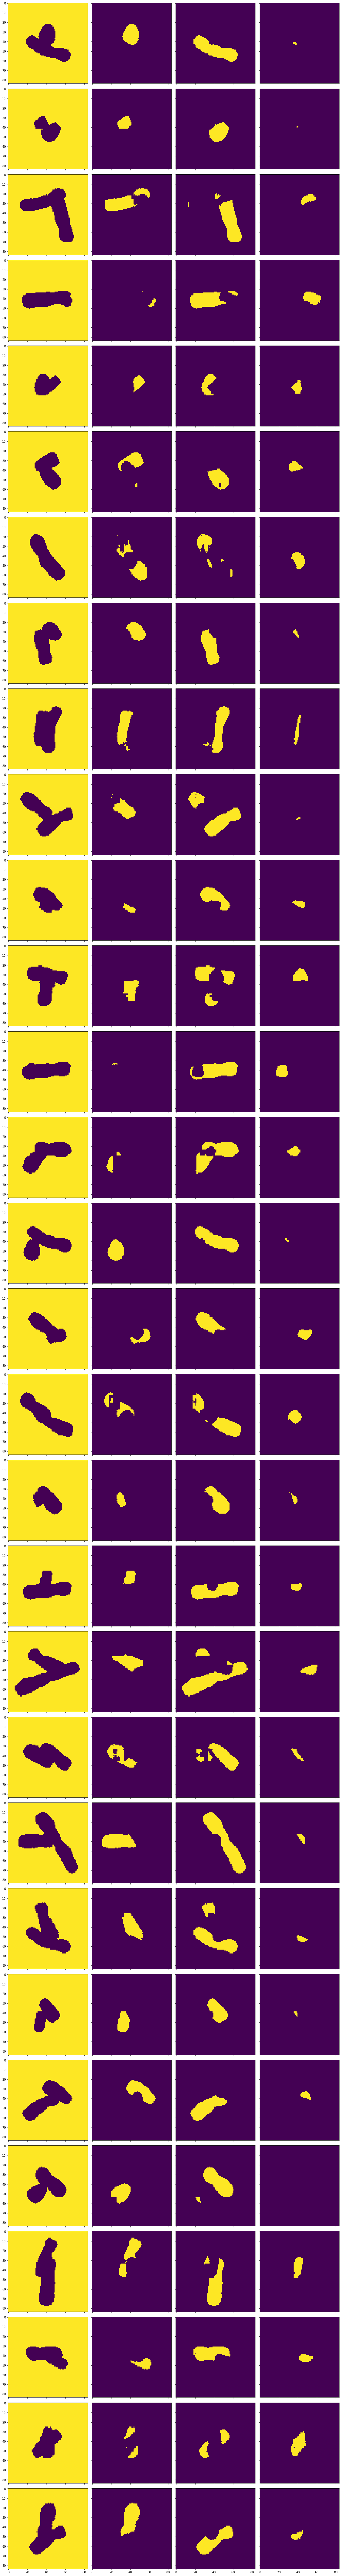

In [195]:
name = 'Unet_1'
os.makedirs('models', exist_ok=True)
filename = 'models/savedmodel_' + name
model.save(filename)

# Predict and plot images
predictions = model.predict(xdata[13000:13030,...])
plotSamplesOneHots(predictions[0:30,...].round())

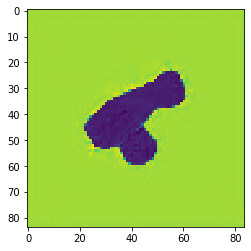

In [173]:
plt.imshow(predictions[0][...,0])

In [88]:
xdata[0:1,...].shape

(1, 84, 84, 1)

In [ ]:
# The Input change to your segmentation data

from PIL import Image,ImageFilter,ImageEnhance,ImageOps,ImageChops,ImageDraw
import matplotlib.pyplot as plt
# Predict our images
img = Image.open('test.jpg')
img = img.resize((84,84))
gray = img.convert('L')
# plt.imshow(img)
gray = np.array(gray)
def rgb2gray(rgb):
    return np.dot(rgb[...,:3], [0.299, 0.587, 0.114])
gray = 255 - gray
plt.imshow(gray)
gray = gray.reshape(84,84,1)
input = makeXbyY(gray, 84, 84).reshape((1, 84, 84, 1))

In [175]:
prediction = model.predict(input)

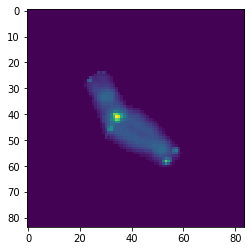

In [129]:
plt.imshow(xdata[7,...].reshape(84,84))  # show the dataset